___
# <font color= #8A0829> Laboratorio de Modelado de Datos </font>
- <Strong> Nombre: </Strong>  <font color="blue"> `Viviana Toledo De la Fuente` </font>
- <Strong> Fecha </Strong>: 08/09/2024.
- <Strong> Correo: </Strong>  <font color="blue"> `viviana.toledo@iteso.mx` </font>
___


### <font color= #2E9AFE> Tarea 2: Análisis de Regresión Lineal</font>

La tarea consiste en ajustar un modelo de regresión lineal para predecir la variable objetivo, pero no se trata solamente de ejecutar el modelo. La tarea implica varias etapas:

1. **Cargar y explorar el conjunto de datos**

- Explora el conjunto de datos y describe brevemente las variables involucradas.
- Si el dataset tiene valores nulos, justifica una estrategia para tratar estos valores.
- Divide tus datos en un 80% de entrenamiento y 20% de prueba antes de realizar cualquier pre-procesamiento. 

2. **Preprocesamiento de los datos**

- Escala las variables predictoras, si es necesario, y explica por qué el escalamiento puede ser importante en la regresión lineal.
- Realiza una selección de características utilizando algún método (puedes sugerir algún método como correlación, RFE o análisis de varianza). Justifica tus decisiones.

3. **Verificación de las suposiciones del modelo**

- Verifica las suposiciones de la regresión lineal con visualizaciones y estadísticas.
- Si alguna suposición no se cumple, describe cómo impactaría en el modelo y realiza alguna acción para corregirla (como transformación de variables, eliminación de outliers, etc.).

4. **Detección de multicolinealidad**

- Calcula el VIF (Variance Inflation Factor) para detectar multicolinealidad entre las variables independientes.
Si detectas multicolinealidad, realiza la eliminación de variables y justifica por qué las variables eliminadas son redundantes.


5. **Entrenamiento y validación del modelo**

- Para este paso ya debiste de tener tus datos divididos en entrenamiento y prueba. Entrena el modelo utilizando regresión lineal y evalúa su rendimiento en el conjunto de prueba.
- Implementa cross-validation (5 o 10 folds) y reporta las métricas promedio (MSE, R²).
- Compara los resultados obtenidos con y sin cross-validation. ¿Cómo varían los resultados y qué conclusiones puedes extraer de ello?

6. **Interpretación de los coeficientes**

- Interpreta los coeficientes del modelo final y discute cuáles son las variables más importantes para predecir la variable objetivo.
- ¿Cómo afectan los signos y magnitudes de los coeficientes a la interpretación del modelo?

7. **Mejora del modelo**

- Si el modelo presenta un mal ajuste, propón al menos dos formas de mejorarlo. Puedes sugerir la introducción de polinomios, interacciones entre variables, o algún otro tipo de transformación.
- Evalúa si las mejoras introducidas realmente generan un mejor desempeño del modelo.


### Evaluación

- Preprocesamiento y exploración de datos (20%)
- Verificación de suposiciones y multicolinealidad (25%)
- Entrenamiento y evaluación del modelo (25%)
- Interpretación y justificación (15%)
- Mejora del modelo (15%)

## Introducción

En el presente trabajo, se analizará un conjunto de datos con el objetivo de elaborar un modelo lineal. Con este modelo se pretende obtener las tendencias más importantes de los datos, para predecir los goals que se anotarán en cada partido, independientemente del equipo que los anote.

## Desarrollo

### Exploración

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_excel('../data/raw/tarea2/datos_football.xlsx')
df.head()

,Team,Total Matches,Wins,Win %,Goals scored,Goals per match
0,Brazil,985,629,63.86,2161,2.19
1,Spain,705,411,58.30,1420,2.01
2,Germany,961,560,58.27,2144,2.23
3,England,1020,580,56.86,2230,2.19
4,Iran,502,275,54.78,932,1.86


In [45]:
df.shape

(195, 6)

<Axes: >

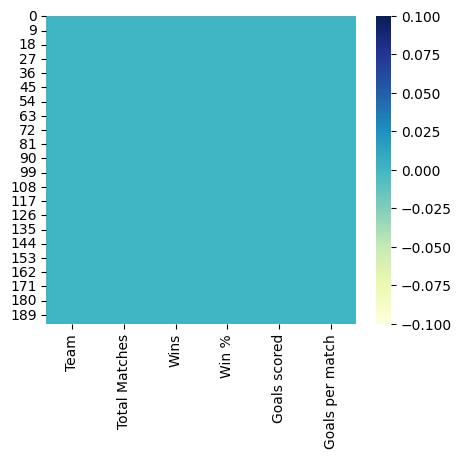

In [46]:
plt.figure(figsize=(5,4))
sns.heatmap(df.isna(), cmap="YlGnBu", mask=df.isna())

No existen datos faltantes en el dataset. Contamos con 5 features y 1 target. De las features, una es una variable categórica, y las demás son numéricas.

Debido a que nuestro interés es predecir los goals por partido, sin importar el equipo que los anote, droppearemos la variable categórica.

In [47]:
df = df.drop('Team', axis='columns')
df.head()

,Total Matches,Wins,Win %,Goals scored,Goals per match
0,985,629,63.86,2161,2.19
1,705,411,58.30,1420,2.01
2,961,560,58.27,2144,2.23
3,1020,580,56.86,2230,2.19
4,502,275,54.78,932,1.86


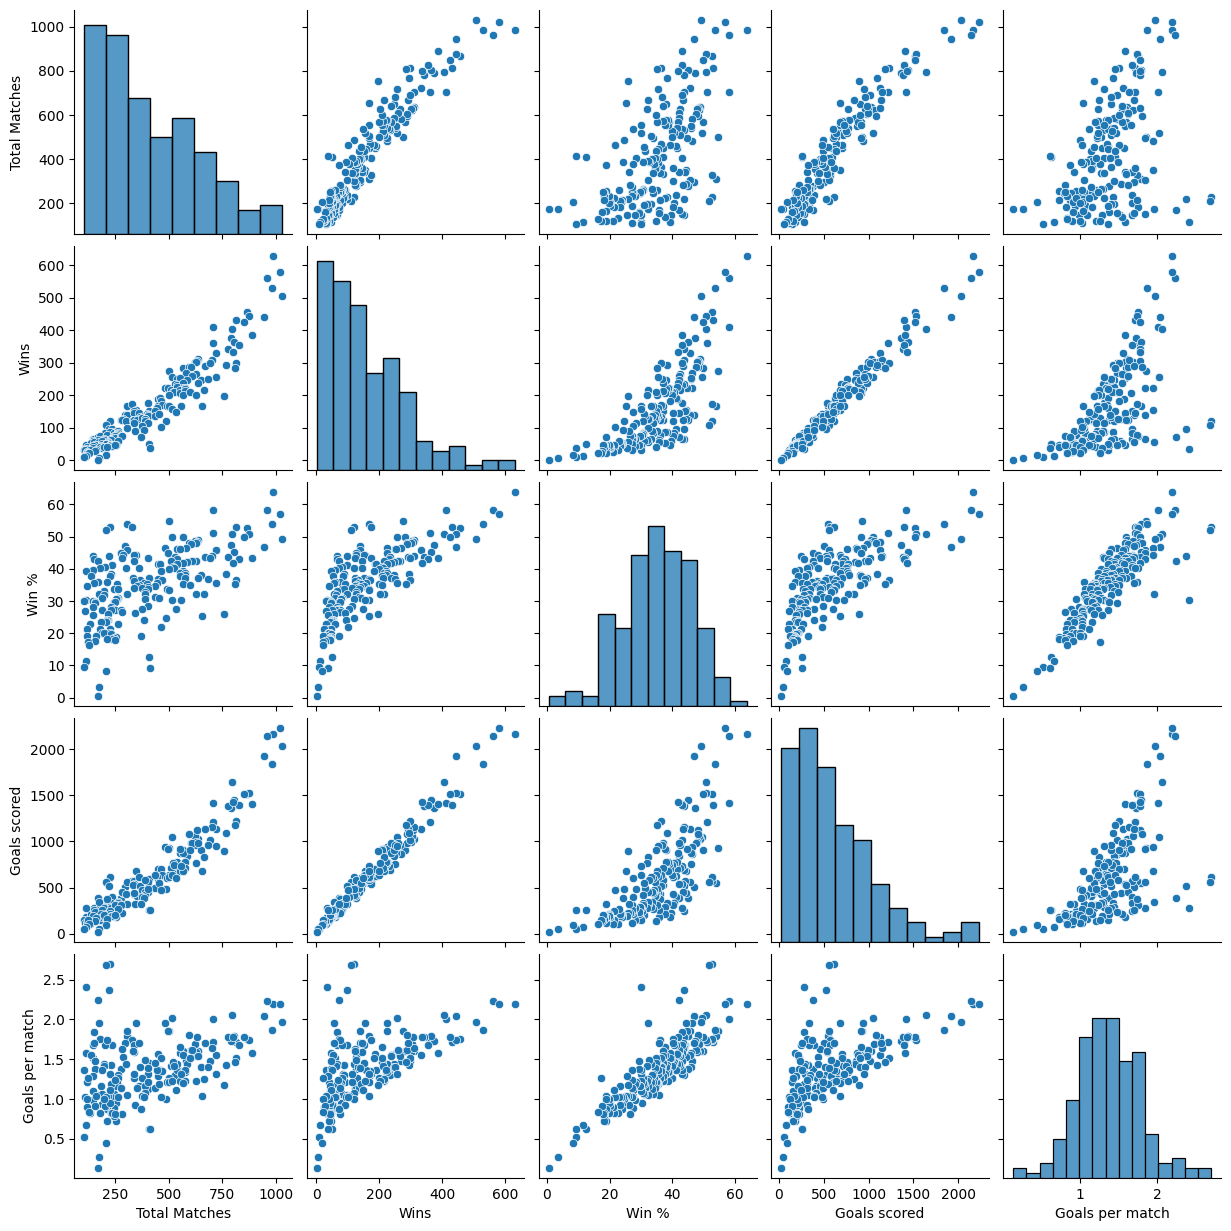

In [48]:
sns.pairplot(df)

Los goals per match parecen tener una relación lineal con el porcentaje de partidos ganados. Además, lo mismo ocurre con los partidos totales y goals scored + wins. 

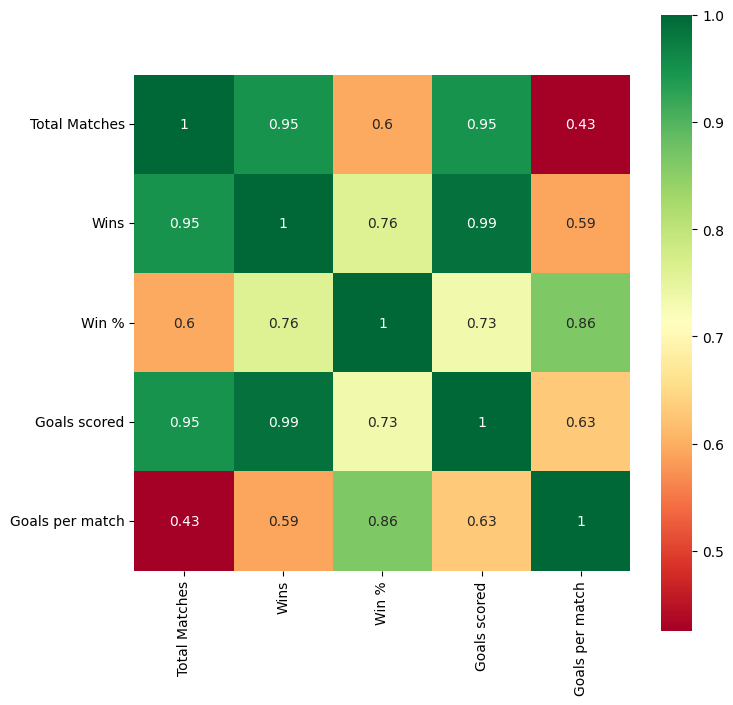

In [49]:
plt.figure(figsize=(8,8))
p=sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',square=True)

La correlación entre (goals scored, wins) es demasiado alta, así como la de (win %, goals per match). Esto puede generar problemas en nuestro modelo.

### Preprocesamiento - Selección de Variables

In [50]:
# Dividiendo las features de la target 
x = df.drop(['Goals per match'],axis=1)
y = df['Goals per match']

# Dividiendo el modelo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 420, test_size=0.2)

Debido a que las variables de entrada y salida son numéricas, utilizaremos una selección de variables Pearson. 

In [51]:
def calcDrop(res):
    # Obtener todas las variables con una correlacion  > 0.6
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # Todas las variables únicas en las columnas a remover
    poss_drop = list(set(res['drop'].tolist()))

    # Quedarse con las variables que no estén en las variables a remover
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop


def corrX_new(df, cut=0.6):
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis=1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(bool))
    
    dropcols = list()
    results = []
    
    for row in range(len(up) - 1):
        col_idx = row + 1
        for col in range(col_idx, len(up)):
            if corr_mtx.iloc[row, col] > cut:
                if avg_corr.iloc[row] > avg_corr.iloc[col]: 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([corr_mtx.index[row],
                               up.columns[col],
                               avg_corr[row],
                               avg_corr[col],
                               up.iloc[row, col],
                               drop],
                              index=['v1', 'v2', 'v1.target', 'v2.target', 'corr', 'drop'])
        
                results.append(s)
    
    # Concatenate all collected Series into a DataFrame
    res = pd.concat(results, axis=1).T.reset_index(drop=True)
    
    dropcols_names = calcDrop(res)
    
    return dropcols_names

drop = corrX_new(X_train)
print(drop)

['Wins', 'Goals scored']


C:\Users\Viviana\AppData\Local\Temp\ipykernel_5928\3037134391.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_corr[row],
C:\Users\Viviana\AppData\Local\Temp\ipykernel_5928\3037134391.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_corr[col],


El método de selección de variables indica que deberíamos remover las features 'Goals scored' y 'Wins'

In [52]:
X_train = X_train.drop(drop, axis='columns')
X_test = X_test.drop(drop, axis='columns')

X_train

,Total Matches,Win %
71,502,39.84
102,400,35.25
150,232,27.16
25,790,47.47
143,149,28.19
...,...,...
31,552,46.01
63,459,41.39
134,116,30.17
72,149,39.60


### Preprocesamiento - Estandarización

Debido a que las features que nos quedan para realizar el modelo ('Total Matches' y 'Win %') cuentan con rangos distintos, aplicaremos una estandarización a los datos. Esta técnica se escogió por encima de la normalización MinMax debido a su utilidad para los modelos lineales.

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Entrenamiento del Modelo

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_train = lin_reg.predict(X_train_scaled)
y_pred_test = lin_reg.predict(X_test_scaled)

ValueError: x and y must be the same size

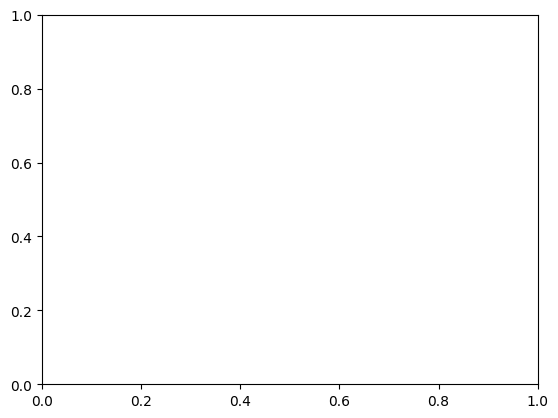

In [59]:
plt.scatter(X_train_scaled, [y_train], color='g')
plt.plot(X_train_scaled, y_pred_train, color='k')

plt.show()

### Comprobación de los Supuestos de Regresión Lineal

#### Linealidad - ✔

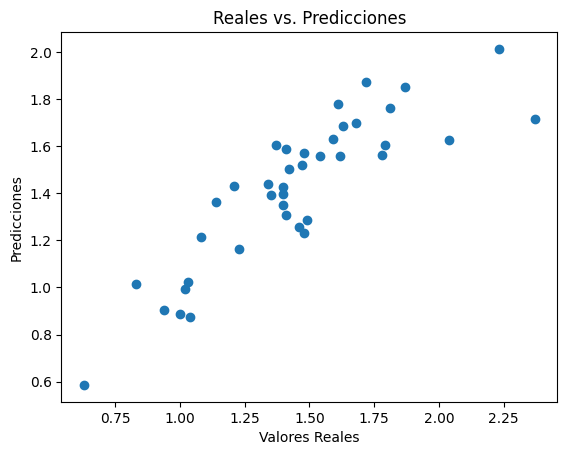

In [60]:
plt.scatter(y_test, y_pred_test)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Reales vs. Predicciones")
plt.show()

Como podemos ver en la gráfica anterior, los datos pueden ser comprendidos en una línea recta, comprobando la linealidad de los datos. 

#### No Multicolinealidad - ✔

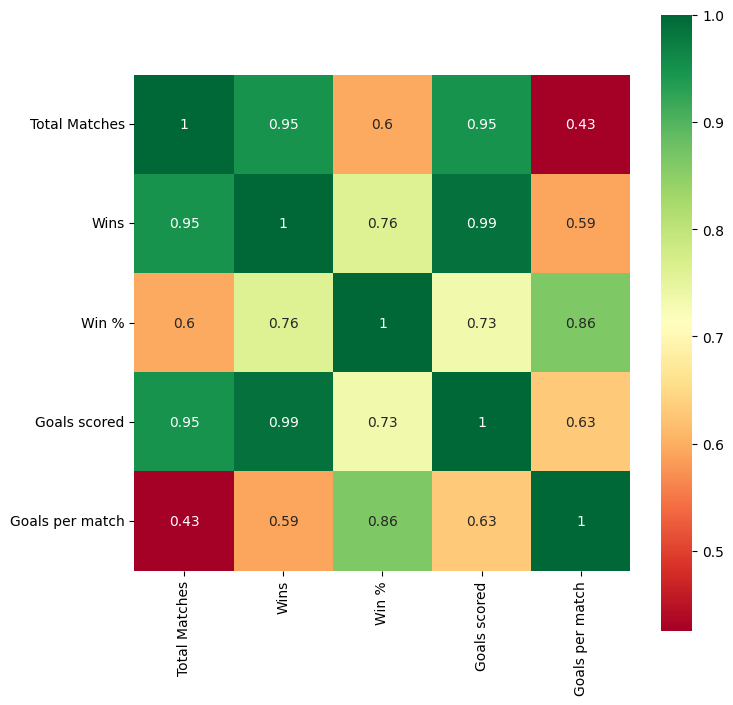

In [63]:
plt.figure(figsize=(8,8))
p=sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',square=True)

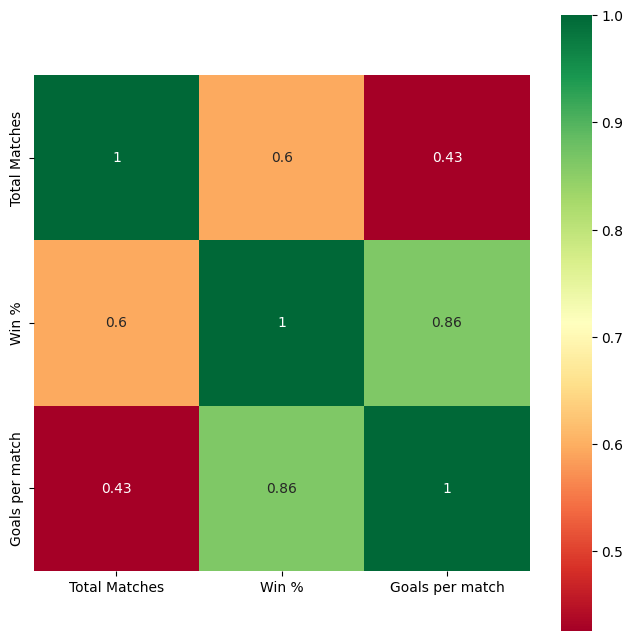

In [70]:
plt.figure(figsize=(8,8))
p=sns.heatmap(df[['Total Matches', 'Win %', 'Goals per match']].corr(), annot=True,cmap='RdYlGn',square=True)

Como observamos al inicio, las features están altamente correlacionadas, particularmente 'Goals scored' y 'Wins' (0.99). Por lo que las eliminamos de nuestro modelo. 

Las features que utilizamos para elaborar el modelo no tienen una correlación muy alta entre sí. 

#### Homoscedasticidad - ✔

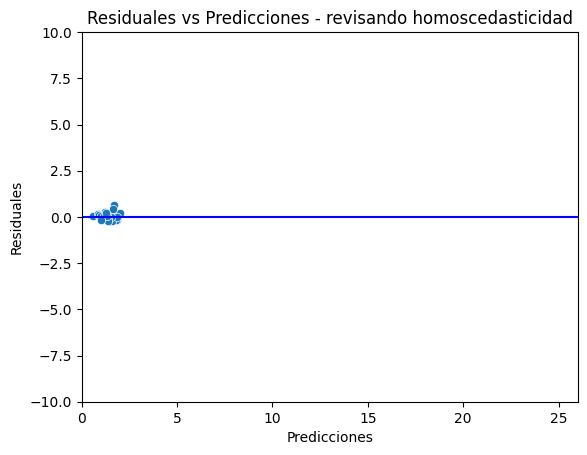

In [62]:
#buscamos patrones en los residuales. Si no hay patrones y están de forma aleatoria graficados entonces es bueno
residuales = y_test - y_pred_test
p = sns.scatterplot(x=y_pred_test, y=residuales)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot(x=[0,26],y=[0,0],color='blue')
p = plt.title('Residuales vs Predicciones - revisando homoscedasticidad')

La variabilidad de los datos es consistente, por lo que se cumple el suspuesto de Homoscedasticidad.

#### Normalidad en los residuales ❌

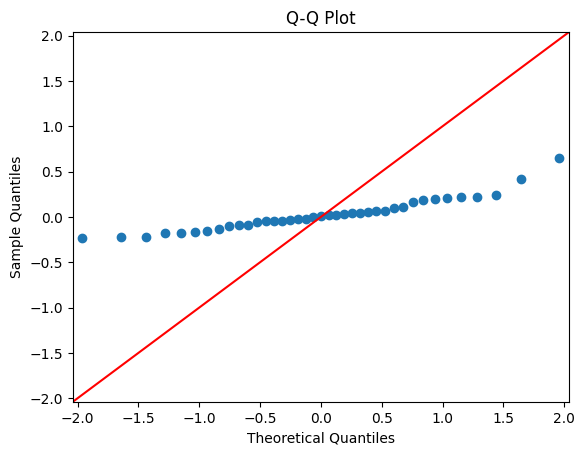

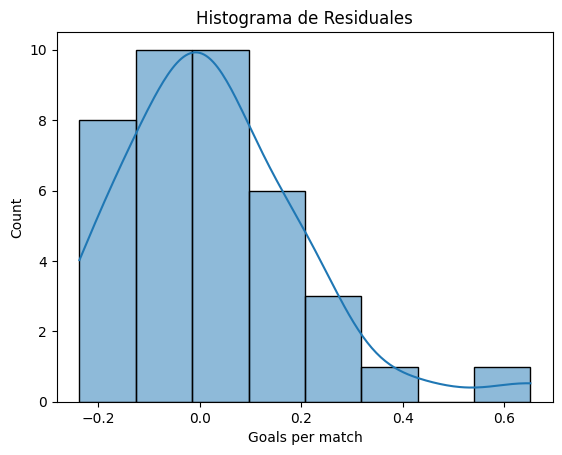

Shapiro-Wilk Test p-value: 0.009788392930574402


In [71]:
import statsmodels.api as sm
import scipy.stats as stats
sm.qqplot(residuales, line='45')
plt.title("Q-Q Plot")
plt.show()

# Alternativamente, usamos un histograma
sns.histplot(residuales, kde=True)
plt.title("Histograma de Residuales")
plt.show()

# Shapiro-Wilk test para la normalidad
shapiro_test = stats.shapiro(residuales)
print(f'Shapiro-Wilk Test p-value: {shapiro_test.pvalue}')

Como podemos observar, el histograma de los residuales no sigue una distribución normal. Además, los datos en el Q-Q plot no están alineados con la línea. Por lo tanto, el supuesto de normalidad en los residuales no se cumple.

### Validación e Interpretación del Modelo

## Conclusión